## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [47]:
#Importing necessary libraries

import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gzip
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
warnings.filterwarnings('ignore')

## Importing the data

In [48]:
#read in movie budgets dataset
movie_budgets = pd.read_csv("/Users/lkimball/Desktop/Flatiron/Movie-Studio-Data-Analysis/Eduardo/zippedData/tn.movie_budgets.csv.gz")

#reading in tmdb movies dataset
tmdb_movies = pd.read_csv("/Users/lkimball/Desktop/Flatiron/Movie-Studio-Data-Analysis/Eduardo/zippedData/tmdb.movies.csv.gz")

#opening reviews dataset
with gzip.open("/Users/lkimball/Desktop/Flatiron/Movie-Studio-Data-Analysis/Eduardo/zippedData/rt.reviews.tsv.gz", 'rt', errors='replace') as file:
    reviews = pd.read_csv(file, delimiter = '\t')

#opening movie info dataset
with gzip.open("/Users/lkimball/Desktop/Flatiron/Movie-Studio-Data-Analysis/Eduardo/zippedData/rt.movie_info.tsv.gz", 'rt', errors='replace') as file:
    movie_info = pd.read_csv(file, delimiter = '\t')

#opening movie gross dataset
with gzip.open("/Users/lkimball/Desktop/Flatiron/Movie-Studio-Data-Analysis/Eduardo/zippedData/bom.movie_gross.csv.gz", 'rt', errors='replace') as file:
    movie_gross = pd.read_csv(file, delimiter = '\t')

#creating sql connection
conn = sqlite3.Connection("/Users/lkimball/Desktop/im.db")

In [49]:
df_list = ['conn','movie_gross','movie_info','reviews','tmdb_movies','movie_budgets']

### Exploring the IM Database

In [50]:
pd.read_sql("""SELECT name, sql FROM sqlite_master WHERE type='table';""",conn)

,name,sql
0,movie_basics,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,directors,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,known_for,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,movie_akas,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,movie_ratings,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,persons,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,principals,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,writers,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [52]:
pd.read_sql("""SELECT * FROM movie_basics LIMIT 2""",conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [53]:
pd.read_sql("""SELECT * FROM directors LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585


In [54]:
pd.read_sql("""SELECT * FROM known_for LIMIT 2""",conn)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241


In [55]:
pd.read_sql("""SELECT * FROM movie_akas LIMIT 2""",conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0


In [56]:
pd.read_sql("""SELECT * FROM movie_ratings LIMIT 2""",conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [57]:
pd.read_sql("""SELECT * FROM persons LIMIT 2""",conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"


In [58]:
pd.read_sql("""SELECT * FROM principals LIMIT 2""",conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None


In [59]:
pd.read_sql("""SELECT * FROM writers LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726


Based on this preliminary exploration, we can evaluate the content of every table within thew database, creating tin that way one solely chart that will have all we need for further exploration

We're going to evaluate what makes a movie win awards, so let's dive in what we need from each table.

movie_basics: We need the name of the movie, the runtime in minutes thast it playead and the genres, we decided to keep both the primary and the original name, to evaluate later which one is easire to pair the other dataframes with

directors: We're going to add the director of each movie.

known_for: We don't find any relevant information to add.

movie_akas: We don;t find any relevant information to add.

movie_ratings: We might want to see if there's any correlation in the awards and the rating and votes they get.

persons: We need the name of the directors of our movies, We also want to know if the person is still alive

principal: Having found above the relevant information about the directors, we don't need the information about them.

writers: We don't find any relevant information to add.

### Movie_ratings

We're evaluating if the amount of votes will be a necessary value to keep, we plot an histogram on a logaritmic scale.

This Column has a mean of 3523.66 a median of 49.0 and a standard deviation of 30294.02, is not worth to keep, is far from normally distributed


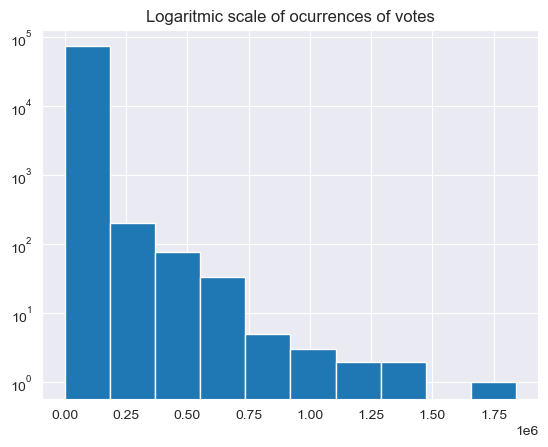

In [60]:
votes = pd.read_sql("""SELECT * FROM movie_ratings """,conn)['numvotes']
plt.hist(votes, log=True);
plt.title('Logaritmic scale of ocurrences of votes');
print(f"This Column has a mean of {round(votes.mean(),2)} a median of {votes.median()} and a \
standard deviation of {round(votes.std(),2)}, is not worth to keep, is far from normally distributed")

Now on the average rating, we evaluate the distribution.

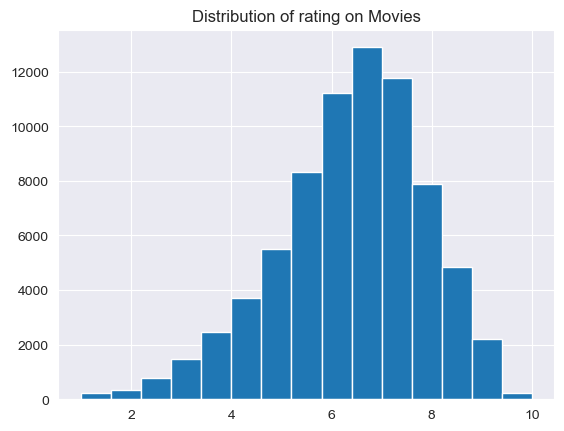

In [61]:
rating = pd.read_sql("""SELECT * FROM movie_ratings""",conn)['averagerating']
plt.hist(rating, bins=15);
plt.title('Distribution of rating on Movies');

We notice that the average rating has a normal distribution, we're going to keep it for further analysis.

## Creating the Query to extract the desired DataFrame

In [62]:
#Creating a Query for this database to Extract the Desired Data From it

imdb = pd.read_sql("""
SELECT primary_title, original_title, start_year, runtime_minutes, primary_name AS director_name, death_year, averagerating, genres
FROM movie_basics
LEFT JOIN directors USING(movie_id)
LEFT JOIN persons USING(person_id)
LEFT JOIN movie_ratings USING(movie_id)
GROUP BY movie_id
""",conn)

## Dealing with the Genre

As we notice above, the genres column has more than one value per movie, that'd make it hard to analyze going forward. We decided isntead to created columns for the different genres and assign a binary value in case the movie falls into that specific genre.

In [63]:
#We make sure that every row has a value in the genre column.
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb['genres'].fillna('No Genre', inplace=True)
# Split the 'genres' column into a list of genres and then explode them into separate rows
imdb['genres'] = imdb['genres'].str.split(',')
imdb = imdb.explode('genres')
# Create binary indicators for each genre
for genre in imdb['genres'].dropna().unique():
    imdb[genre] = imdb['genres'].str.contains(genre).astype(int)
# Drop the original genres column
imdb.drop(columns=['genres'], inplace=True)

That made what we needed, but now we have as many rows per movie as genres they're in, we need to consolidate them

In [64]:
# Separate what are "genres column" from "non genres column"
non_genre_columns = ['primary_title', 'original_title','start_year','runtime_minutes','director_name','death_year','averagerating']
genre_columns = imdb.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = imdb.groupby('primary_title', as_index=False)[genre_columns].sum()

#Merging all the columns together
imdb = pd.merge(imdb[non_genre_columns], genres_consolidated, on='primary_title')
#Elimintating duplicates based on primary_title
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb.reset_index(drop=True, inplace=True)

### Dealing with null values

In [65]:
imdb['Action'].value_counts()

0    126541
1      9530
Name: Action, dtype: int64

In [66]:
#If we don't have the original_title, we'll just keep the primary_title.
imdb['original_title'].fillna(imdb['primary_title'], inplace=True)
#For runtime_minutes and death_year, we'll use 0 as a placeholder value
imdb['runtime_minutes'].fillna(0, inplace=True)
imdb['death_year'].fillna(0, inplace=True)
#For directors, we'll replace with 'Unknown'
imdb['director_name'].fillna('Unknown',inplace=True)
#For the averagerating we decided to fill the null values with the median.
imdb['averagerating'].fillna(imdb['averagerating'].median(),inplace=True)



In [67]:
imdb['Adventure'].value_counts()

0    129967
1      6104
Name: Adventure, dtype: int64

## Movie_gross
Since we're going to work only with US based awards, we're going to focus on domestic gross rather than foreign_gross.

We drop all the columns and rows that we don't need or are irrelevant for our analysis.

In [68]:
#Dropping unnecessary columns and rows
movie_gross.drop(columns=['studio','year','foreign_gross'],inplace=True)
movie_gross.dropna(axis=0, inplace=True)
movie_gross.info()

KeyError: "['studio', 'year', 'foreign_gross'] not found in axis"

## TMDB movies

In [69]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [70]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [71]:
#Keeping just the release year instead of the full date
tmdb_movies['release_year'] = tmdb_movies['release_date'].str[:4]
# drop unnecessary columns
tmdb_movies.drop(columns=['Unnamed: 0','original_language','popularity','vote_average','vote_count','release_date'],inplace=True)
# Keep just the year inthe release date

## Genre unification
In this dataframe, the Genre column was identified just as ids. Founding online a dictionary with the corresponding Genre by map.
We're able to replace the numbers by the actual genre name.

After doing this, we found the same issue that on our IMBD database, having the genres combined instead of separated. Therefore, we create a new set of columns for the genres with binary values if the movie belongs to it

In [72]:
genre_mapping = {12: 'Adventure',
                 14: 'Fantasy',     
                 16: 'Animation',     
                 18: 'Drama',     
                 27: 'Horror',     
                 28: 'Action',     
                 35: 'Comedy',     
                 36: 'History',     
                 37: 'Western',     
                 53: 'Thriller',     
                 80: 'Crime',     
                 99: 'Documentary',     
                 9648: 'Mystery',     
                 10402: 'Music',     
                 10749: 'Romance',     
                 10751: 'Family',     
                 10752: 'War',     
                 10770: 'TV Movie',     
                 878: 'Science Fiction'} 

def map_genre_ids(ids_str):
    ids = eval(ids_str)
    genres = [genre_mapping.get(id, 'Unknown') for id in ids]
    return ','.join(genres)
    
tmdb_movies['genres'] = tmdb_movies['genre_ids'].apply(map_genre_ids)
tmdb_movies.drop(columns='genre_ids',inplace=True)
tmdb_movies.loc[tmdb_movies['genres'] == '', 'genres'] = 'Unknown'

In [73]:
#We make sure that every row has a value in the genre column.
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])

# Split the 'genres' column into a list of genres and then explode them into separate rows
tmdb_movies['genres'] = tmdb_movies['genres'].str.split(',')

tmdb_movies = tmdb_movies.explode('genres')

# Create binary indicators for each genre
for genre in tmdb_movies['genres'].dropna().unique():
    tmdb_movies[genre] = tmdb_movies['genres'].str.contains(genre).astype(int)
# Drop the original genres column
tmdb_movies.drop(columns=['genres'], inplace=True)

# Separate what are "genres column" from "non genres column"
non_genre_columns = ['id','original_title','title','release_year']
genre_columns = tmdb_movies.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = tmdb_movies.groupby('id', as_index=False)[genre_columns].sum()

#Merging all the columns together
tmdb_movies = pd.merge(tmdb_movies[non_genre_columns], genres_consolidated, on='id')
#Elimintating duplicates based on primary_title
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])
tmdb_movies.reset_index(drop=True, inplace=True)

## Movie_budgets

In [74]:
#converting columns from string to numeric data types
columns_to_convert = ['worldwide_gross', 'production_budget', 'domestic_gross']
for col in columns_to_convert:
    movie_budgets[col] = pd.to_numeric(movie_budgets[col].str.replace('[$,]', '', regex=True), errors='coerce')
#creating a new column for worldwide_gross/production_budget measuring the amount made vs the amount spent
movie_budgets['worldwide_gross/production_budget'] = movie_budgets['worldwide_gross']/movie_budgets['production_budget']
#doing the same but for domestic gross
movie_budgets['domestic_gross/production_budget'] = movie_budgets['domestic_gross']/movie_budgets['production_budget']
#checking that it worked
movie_budgets.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,6.532577,1.78943


## Awards Database

Since we're trying to figure out which movies provide the most awards, we got access to a Database of the golge globe Awards from 1944 to 2020.

We'll try to explore the data to determine which factors make a movie worth of awards

In [75]:
#Import the Golden Globe Database
golden_globe_awards = pd.read_csv('golden_globe_awards.csv')

### Exploring the data

In [76]:
golden_globe_awards.head()

,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [77]:
golden_globe_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_film   7991 non-null   int64 
 1   year_award  7991 non-null   int64 
 2   ceremony    7991 non-null   int64 
 3   category    7991 non-null   object
 4   nominee     7991 non-null   object
 5   film        6191 non-null   object
 6   win         7991 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 382.5+ KB


In [78]:
#Keeping only the winners, and dropping unnecessary columns
#When the nominee was the movie itself instead of an specific Crew member, the film cell was null.
# Having the Name of the film in the 'nominee' column. We replace accordingly
golden_globe_awards = golden_globe_awards.loc[golden_globe_awards['win'] == True]
golden_globe_awards.drop(columns=['year_award','ceremony','win'],inplace=True)
golden_globe_awards['film'] = golden_globe_awards['film'].fillna(golden_globe_awards['nominee'])

In [79]:
#Removing awards not related to US movies
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Television')]
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Foreign')]

In [80]:
golden_globe_awards['category'].value_counts()

Best Performance by an Actress in a Supporting Role in any Motion Picture    79
Best Performance by an Actor in a Supporting Role in any Motion Picture      77
Best Director - Motion Picture                                               77
Best Performance by an Actor in a Motion Picture - Drama                     71
Best Performance by an Actress in a Motion Picture - Drama                   71
Best Performance by an Actor in a Motion Picture - Musical or Comedy         70
Best Motion Picture - Drama                                                  69
Best Original Score - Motion Picture                                         66
Best Screenplay - Motion Picture                                             63
Best Motion Picture - Musical or Comedy                                      63
New Star Of The Year - Actress                                               60
Henrietta Award (World Film Favorites)                                       59
Best Original Song - Motion Picture     

In [81]:
#Unifying categories to keep just the ones that include Crew's individual work, production type or the movie as a whole
def cat_cleaner(char, cat):
    for i in char:
        golden_globe_awards.loc[golden_globe_awards['category'].str.contains(i,case=False), 'category'] = cat

crew_member = ['actress','actor','director','new star']
production = ['cinematography','screenplay','song','use of color']
cat_cleaner(crew_member, 'Crew member')
cat_cleaner(production, 'Production')
cat_cleaner(overall_movie, 'Overall Movie')

golden_globe_awards.loc[((golden_globe_awards['category'] != 'Crew member') & (golden_globe_awards['category'] != 'Production')), 'category'] = 'Overall Movie' 

In [82]:
golden_globe_awards['category'].value_counts()

Crew member      651
Overall Movie    330
Production       135
Name: category, dtype: int64

In [83]:
golden_globe_awards.head()

,year_film,category,nominee,film
0,1943,Crew member,Katina Paxinou,For Whom The Bell Tolls
1,1943,Crew member,Akim Tamiroff,For Whom The Bell Tolls
2,1943,Crew member,Henry King,The Song Of Bernadette
3,1943,Overall Movie,The Song Of Bernadette,The Song Of Bernadette
4,1943,Crew member,Jennifer Jones,The Song Of Bernadette


In [84]:
yearly = golden_globe_awards.groupby('year_film').count()

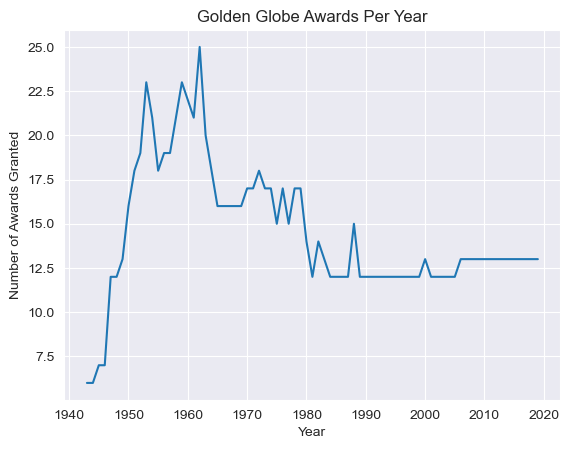

In [85]:
sns.set_style('darkgrid')
sns.lineplot(x = yearly.index, y = yearly['category'])
plt.title('Golden Globe Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted');

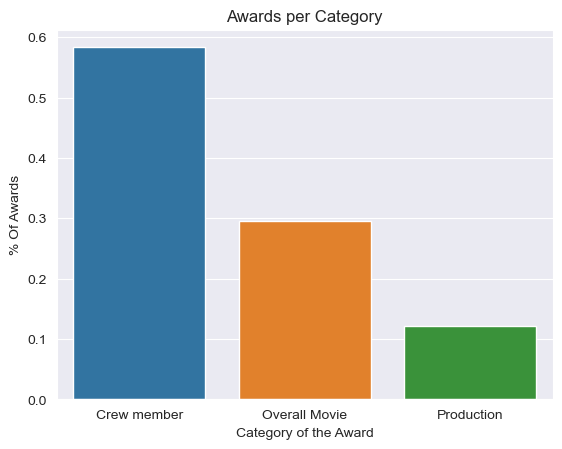

In [86]:
golden_glob_categories = golden_globe_awards['category'].value_counts(normalize=True)
sns.barplot(x = golden_glob_categories.index, y = golden_glob_categories)
plt.title('Awards per Category')
plt.xlabel('Category of the Award')
plt.ylabel('% Of Awards');

In [87]:
nominees = golden_globe_awards.groupby('nominee').count()
nominees.sort_values(by='year_film', ascending=False)

,year_film,category,film
nominee,,,
Jane Fonda,7,7,7
Meryl Streep,7,7,7
Barbra Streisand,7,7,7
Jack Nicholson,6,6,6
Paul Newman,5,5,5
...,...,...,...
"Godfather, The",1,1,1
Going My Way,1,1,1
Goldie Hawn,1,1,1


In [88]:
nominees.index.isin(imdb['director_name']).sum()

81

In [89]:
films = golden_globe_awards.groupby('film').count()
films

,year_film,category,nominee
film,,,
12 Years a Slave,1,1,1
1917,2,2,2
5 Fingers,1,1,1
A Beautiful Mind,4,4,4
A Double Life,1,1,1
...,...,...,...
You Light Up My Life,1,1,1
Young Guns II,1,1,1
Youthquake,1,1,1


In [90]:
films.index.isin(imdb['primary_title']).sum()

164

## Academy Awards

In [91]:
academy_awards = pd.read_csv('academy_awards.csv')
academy_awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [92]:
academy_awards.isna().sum()

Year           0
Ceremony       0
Award          0
Winner      7643
Name           0
Film         333
dtype: int64

In [93]:
academy_awards.dropna(subset = 'Winner', axis=0, inplace = True)
academy_awards.drop(columns=['Winner','Ceremony'],inplace=True)
academy_awards['Year'] = academy_awards['Year'].str.slice(0,4)

In [94]:
academy_awards['Award'].unique()

array(['Actor', 'Actress', 'Art Direction', 'Cinematography',
       'Directing (Comedy Picture)', 'Directing (Dramatic Picture)',
       'Engineering Effects', 'Outstanding Picture',
       'Unique and Artistic Picture', 'Writing (Adaptation)',
       'Writing (Original Story)', 'Writing (Title Writing)',
       'Special Award', 'Directing', 'Writing', 'Outstanding Production',
       'Sound Recording', 'Short Subject (Cartoon)',
       'Short Subject (Comedy)', 'Short Subject (Novelty)',
       'Assistant Director', 'Film Editing', 'Music (Scoring)',
       'Music (Song)', 'Dance Direction', 'Writing (Screenplay)',
       'Actor in a Supporting Role', 'Actress in a Supporting Role',
       'Short Subject (Color)', 'Short Subject (One Reel)',
       'Short Subject (Two Reel)', 'Irving G. Thalberg Memorial Award',
       'Music (Original Score)', 'Cinematography (Black and White)',
       'Cinematography (Color)', 'Special Effects',
       'Art Direction (Black and White)', 'Art Direct

In [95]:
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Commendation')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Honorary')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Foreign')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Humanitarian')]
def cat_cleaner(char, cat):
    for i in char:
       academy_awards.loc[academy_awards['Award'].str.contains(i,case=False), 'Award'] = cat

crew_member = ['actress','actor','direct','writing']
production = ['music','cinematography','special ach','effects','sound','costume','makeup','production','editing']
overall_movie = ['documentary','short','picture','special award','feature film','Irving G. Thalberg Memorial Award','Gordon E. Sawyer Award']
cat_cleaner(crew_member, 'Crew member')
cat_cleaner(production, 'Production')
cat_cleaner(overall_movie, 'Overall Movie')

In [96]:
academy_awards['Year'] = academy_awards['Year'].astype(int)

Text(0, 0.5, 'Number of Awards Granted')

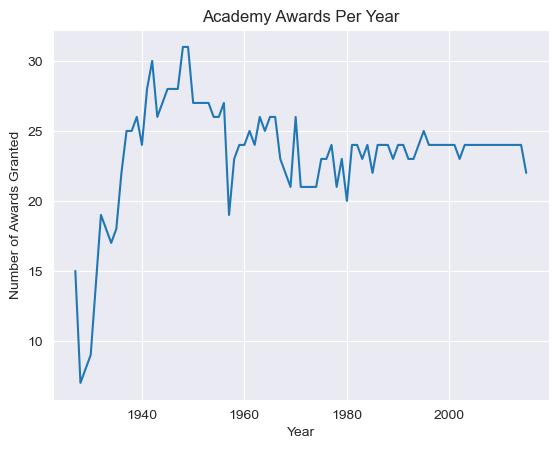

In [97]:
yearly_aa = academy_awards.groupby('Year').count()

sns.set_style('darkgrid')
sns.lineplot(x = yearly_aa.index, y = yearly_aa['Award'])
plt.title('Academy Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted')
#plt.xticks([1925,1935,1945,1955,1965,1975,1985,1995,2005,2015])

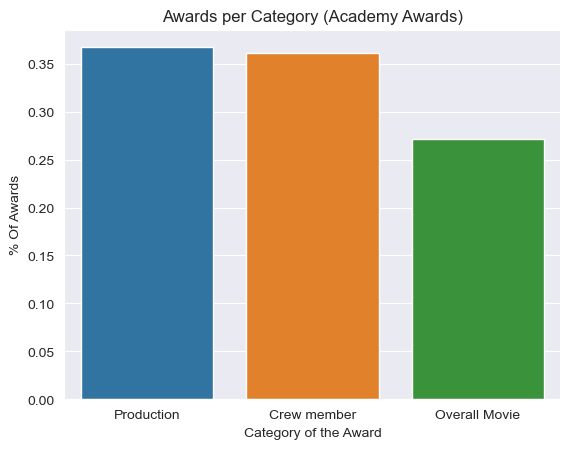

In [98]:
academy_categories = academy_awards['Award'].value_counts(normalize=True)
sns.barplot(x = academy_categories.index, y = academy_categories)
plt.title('Awards per Category (Academy Awards)')
plt.xlabel('Category of the Award')
plt.ylabel('% Of Awards');

In [99]:
nominees_aa = academy_awards.groupby('Name').count()
nominees_aa.sort_values(by='Year', ascending=False)

,Year,Award,Film
Name,,,
Titanic,11,11,11
The Lord of the Rings: The Return of the King,10,10,10
Ben-Hur,9,9,9
The Last Emperor,9,9,9
West Side Story,8,8,8
...,...,...,...
Green Dolphin Street,1,1,1
Great,1,1,1
Gravity Is My Enemy,1,1,1


In [100]:
nominees_aa.index.isin(imdb['director_name']).sum()

31

In [101]:
films_aa = academy_awards.groupby('Film').count()
films

,year_film,category,nominee
film,,,
12 Years a Slave,1,1,1
1917,2,2,2
5 Fingers,1,1,1
A Beautiful Mind,4,4,4
A Double Life,1,1,1
...,...,...,...
You Light Up My Life,1,1,1
Young Guns II,1,1,1
Youthquake,1,1,1


In [102]:
films_aa.index.isin(imdb['primary_title']).sum()

90

In [103]:
academy_awards

,Year,Award,Name,Film
1,1927,Crew member,Emil Jannings,The Last Command
3,1927,Crew member,Janet Gaynor,7th Heaven
6,1927,Crew member,William Cameron Menzies,The Dove; Tempest
9,1927,Production,Charles Rosher,Sunrise
10,1927,Production,Karl Struss,Sunrise
...,...,...,...,...
9936,2015,Production,Mad Max: Fury Road,Mark Mangini and David White
9942,2015,Production,Mad Max: Fury Road,"Chris Jenkins, Gregg Rudloff and Ben Osmo"
9946,2015,Production,Ex Machina,"Andrew Whitehurst, Paul Norris, Mark Ardington..."
9951,2015,Crew member,The Big Short,Screenplay by Charles Randolph and Adam McKay


In [153]:
golden_globe_awards

,year_film,category,nominee,film,film_cleaned,nominee_cleaned
0,1943,Crew member,Katina Paxinou,For Whom The Bell Tolls,forwhomthebelltolls,katinapaxinou
1,1943,Crew member,Akim Tamiroff,For Whom The Bell Tolls,forwhomthebelltolls,akimtamiroff
2,1943,Crew member,Henry King,The Song Of Bernadette,thesongofbernadette,henryking
3,1943,Overall Movie,The Song Of Bernadette,The Song Of Bernadette,thesongofbernadette,thesongofbernadette
4,1943,Crew member,Jennifer Jones,The Song Of Bernadette,thesongofbernadette,jenniferjones
...,...,...,...,...,...,...
7904,2019,Crew member,Sam Mendes,1917,1917,sammendes
7909,2019,Production,Quentin Tarantino,Once Upon a Time...in Hollywood,onceuponatime...inhollywood,quentintarantino
7914,2019,Overall Movie,Missing Link,Missing Link,missinglink,missinglink
7924,2019,Overall Movie,Hildur Guðnadóttir,Joker,joker,hildurguðnadóttir


Creating a dictionary for the names of movies from the Golden Globes and IMDB and pairing them as key-value pairs by their similarility score

In [105]:
# Remove spaces from movie names and convert to lowercase for easier matching
golden_globe_awards['film_cleaned'] = golden_globe_awards['film'].str.replace(' ', '').str.lower()
imdb['primary_title_cleaned'] = imdb['primary_title'].str.replace(' ', '').str.lower()

In [106]:
# Start the timer
start_time = time.time()


# Initialize an empty list to store pairs
pairs = []

# Set a similarity score threshold (adjust as needed)
threshold = 90

# Perform fuzzy matching and create pairs
for name1 in golden_globe_awards['film_cleaned']:
    for name2 in imdb['primary_title_cleaned']:
        similarity_score = fuzz.ratio(name1, name2)
        if similarity_score >= threshold:
            pairs.append((name1, name2, similarity_score))
            


# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 420.6654849052429 seconds


In [109]:
# Create a DataFrame from the list of matching pairs
matching_pairs_df = pd.DataFrame(pairs, columns=['imdb_primary_title', 'golden_globe_film', 'similarity_score'])

# Merge the two datasets based on the similarity score threshold
merged_data = pd.merge(imdb, matching_pairs_df, left_on='primary_title_cleaned', right_on='imdb_primary_title', how='inner')
merged_data_globes = pd.merge(merged_data, golden_globe_awards, left_on='golden_globe_film', right_on='film_cleaned', how='inner')

# You can drop the extra columns used for matching if needed
merged_data_globes.drop(['imdb_primary_title', 'golden_globe_film', 'original_title' ], axis=1, inplace=True)

In [132]:
#viewing the distribution of similarity scores
#merged_data_globes['similarity_score'].value_counts()
merged_data_globes

,primary_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,Animation,...,War,Western,primary_title_cleaned,similarity_score,year_film,category,nominee,film,film_cleaned,year_difference
0,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,1,...,0,0,toystory3,100,2010,Overall Movie,Toy Story 3,Toy Story 3,toystory3,0
1,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,0,...,0,0,lincoln,100,2012,Crew member,Daniel Day-Lewis,Lincoln,lincoln,0
2,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,0,...,0,0,lifeofpi,100,2012,Overall Movie,Mychael Danna,Life of Pi,lifeofpi,0
3,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,0,...,0,0,dallasbuyersclub,100,2013,Crew member,Matthew McConaughey,Dallas Buyers Club,dallasbuyersclub,0
4,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,0,...,0,0,dallasbuyersclub,100,2013,Crew member,Jared Leto,Dallas Buyers Club,dallasbuyersclub,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,Ray,2018,111.0,Riingo Banerjee,0.0,6.5,0,0,0,0,...,0,0,ray,100,2004,Crew member,Jamie Foxx,Ray,ray,14
651,Green Card,2017,120.0,Rums,0.0,6.5,0,0,0,0,...,0,0,greencard,100,1990,Overall Movie,Green Card,Green Card,greencard,27
652,Green Card,2017,120.0,Rums,0.0,6.5,0,0,0,0,...,0,0,greencard,100,1990,Crew member,Gérard Depardieu,Green Card,greencard,27
653,Green Card,2017,120.0,Rums,0.0,6.5,0,0,0,0,...,0,0,greencard,100,1990,Overall Movie,Green Card,Green Card,greencard,27


In [210]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_globes['year_difference'] = abs(merged_data_globes['start_year'] - merged_data_globes['year_film'])
merged_data_globes1 = merged_data_globes[merged_data_globes['year_difference'] < 2]
#merged_data1['similarity_score'].value_counts()
merged_data_globes1.head(1)

,primary_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,Animation,...,War,Western,primary_title_cleaned,similarity_score,year_film,category,nominee,film,film_cleaned,year_difference
0,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,1,...,0,0,toystory3,100,2010,Overall Movie,Toy Story 3,Toy Story 3,toystory3,0


In [181]:
merged_data_imdb = pd.merge(imdb, matching_pairs_df, left_on='primary_title_cleaned', right_on='imdb_primary_title', how='left')

# Dropping the extra columns
merged_data_imdb.drop(['imdb_primary_title', 'golden_globe_film', 'original_title'], axis=1, inplace=True)
merged_data_imdb

,primary_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,Animation,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,primary_title_cleaned,similarity_score
0,Sunghursh,2013,175.0,Harnam Singh Rawail,2004.0,7.0,1,0,0,0,...,0,0,0,0,0,0,0,0,sunghursh,NaN
1,One Day Before the Rainy Season,2019,114.0,Mani Kaul,2011.0,7.2,0,0,0,0,...,0,0,0,0,0,0,0,0,onedaybeforetherainyseason,NaN
2,The Other Side of the Wind,2018,122.0,Orson Welles,1985.0,6.9,0,0,0,0,...,0,0,0,0,0,0,0,0,theothersideofthewind,NaN
3,Sabse Bada Sukh,2018,0.0,Hrishikesh Mukherjee,2006.0,6.1,0,0,0,0,...,0,0,0,0,0,0,0,0,sabsebadasukh,NaN
4,The Wandering Soap Opera,2017,80.0,Raoul Ruiz,2011.0,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,thewanderingsoapopera,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136272,Kuambil Lagi Hatiku,2019,123.0,Azhar Kinoi Lubis,0.0,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,kuambillagihatiku,NaN
136273,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,0.0,Angela Gurgel,0.0,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,rodolphoteóphilo-olegadodeumpioneiro,NaN
136274,Dankyavar Danka,2013,0.0,Kanchan Nayak,0.0,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,dankyavardanka,NaN
136275,6 Gunn,2017,116.0,Kiran Gawade,0.0,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,6gunn,NaN


In [116]:
#merged_data_imdb.groupby(['start_year','primary_title_cleaned']).count()

Running the same fuzzy matching as before, but on the column 'nominee' to make sure we're not missing any movie matches due to the messy data in the Golden Globes dataset

In [166]:
#making sure we don't duplicate results by removing records that have the same values for film and nominee
mask = golden_globe_awards['film_cleaned'] == golden_globe_awards['nominee_cleaned']

# Use the mask to filter the rows where col1 and col2 have the same value
rows_with_same_values = golden_globe_awards[mask]
golden_globe_awards_nd = golden_globe_awards[~mask]
golden_globe_awards_nd

,year_film,category,nominee,film,film_cleaned,nominee_cleaned
0,1943,Crew member,Katina Paxinou,For Whom The Bell Tolls,forwhomthebelltolls,katinapaxinou
1,1943,Crew member,Akim Tamiroff,For Whom The Bell Tolls,forwhomthebelltolls,akimtamiroff
2,1943,Crew member,Henry King,The Song Of Bernadette,thesongofbernadette,henryking
4,1943,Crew member,Jennifer Jones,The Song Of Bernadette,thesongofbernadette,jenniferjones
5,1943,Crew member,Paul Lukas,Watch On The Rhine,watchontherhine,paullukas
...,...,...,...,...,...,...
7899,2019,Crew member,Brad Pitt,Once Upon a Time...in Hollywood,onceuponatime...inhollywood,bradpitt
7904,2019,Crew member,Sam Mendes,1917,1917,sammendes
7909,2019,Production,Quentin Tarantino,Once Upon a Time...in Hollywood,onceuponatime...inhollywood,quentintarantino
7924,2019,Overall Movie,Hildur Guðnadóttir,Joker,joker,hildurguðnadóttir


In [165]:
# Remove spaces from movie names and convert to lowercase for easier matching
golden_globe_awards_nd['nominee_cleaned'] = golden_globe_awards_nd['nominee'].str.replace(' ', '').str.lower()
imdb['primary_title_cleaned'] = imdb['primary_title'].str.replace(' ', '').str.lower()

In [161]:
# Start the timer
start_time = time.time()


# Initialize an empty list to store pairs
pairs_nominee = []

# Set a similarity score threshold (adjust as needed)
threshold = 90

# Perform fuzzy matching and create pairs
for name1 in golden_globe_awards_nd['nominee_cleaned']:
    for name2 in imdb['primary_title_cleaned']:
        similarity_score = fuzz.ratio(name1, name2)
        if similarity_score >= threshold:
            pairs.append((name1, name2, similarity_score))
            


# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 324.8193259239197 seconds


In [171]:
# Create a DataFrame from the list of matching pairs
pairs_nominee_df = pd.DataFrame(pairs, columns=['imdb_primary_title', 'golden_globe_nominee', 'similarity_score'])

# Merge the two datasets based on the similarity score threshold
merged_data_nominee = pd.merge(imdb, pairs_nominee_df, left_on='primary_title_cleaned', right_on='imdb_primary_title', how='inner')
nominee_globes = pd.merge(merged_data_nominee, golden_globe_awards_nd, left_on='golden_globe_nominee', right_on='nominee_cleaned', how='inner')

# Dropping extra columns used for matching
nominee_globes.drop(['imdb_primary_title', 'golden_globe_nominee', 'original_title', 'nominee' ], axis=1, inplace=True)

In [172]:
nominee_globes

,primary_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,Animation,...,Thriller,War,Western,primary_title_cleaned,similarity_score,year_film,category,film,film_cleaned,nominee_cleaned
0,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
1,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
2,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
3,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
4,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
5,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
6,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
7,Twiggy,2011,81.0,Emmanuelle Millet,0.0,5.7,0,0,0,0,...,0,0,0,twiggy,100,1971,Crew member,"Boy Friend, The","boyfriend,the",twiggy
8,Cantinflas,2014,102.0,Sebastian del Amo,0.0,6.6,0,0,0,0,...,0,0,0,cantinflas,100,1956,Crew member,Around the World in 80 Days,aroundtheworldin80days,cantinflas
9,Cantinflas,2014,102.0,Sebastian del Amo,0.0,6.6,0,0,0,0,...,0,0,0,cantinflas,100,1956,Crew member,Around the World in 80 Days,aroundtheworldin80days,cantinflas


In [170]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
nominee_globes['year_difference'] = abs(nominee_globes['start_year'] - nominee_globes['year_film'])
nominee_globes1 = nominee_globes[nominee_globes['year_difference'] < 2]
#merged_data1['similarity_score'].value_counts()
nominee_globes1

,primary_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,Animation,...,War,Western,primary_title_cleaned,similarity_score,year_film,category,film,film_cleaned,nominee_cleaned,year_difference


In [212]:
#combining the dataframes
Golden_Globes_Winners = pd.concat([nominee_globes1, merged_data_globes1], axis=0)

#reseting the index so no duplicate index numbers
Golden_Globes_Winners.reset_index(drop=True, inplace=True)
Golden_Globes_Winners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   primary_title          220 non-null    object 
 1   start_year             220 non-null    int64  
 2   runtime_minutes        220 non-null    float64
 3   director_name          220 non-null    object 
 4   death_year             220 non-null    float64
 5   averagerating          220 non-null    float64
 6   Action                 220 non-null    int64  
 7   Adult                  220 non-null    int64  
 8   Adventure              220 non-null    int64  
 9   Animation              220 non-null    int64  
 10  Biography              220 non-null    int64  
 11  Comedy                 220 non-null    int64  
 12  Crime                  220 non-null    int64  
 13  Documentary            220 non-null    int64  
 14  Drama                  220 non-null    int64  
 15  Family

In [213]:
#Dropping unnecessary columns
Golden_Globes_Winners.drop(['start_year', 'primary_title_cleaned', 'year_difference'], axis=1, inplace=True)


In [214]:
#dropping duplicate records
Golden_Globes_Winners1 = Golden_Globes_Winners.drop_duplicates()
